# Réduction de l'ordre des modèles - Problèmes paraboliques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse.linalg import eigsh, splu
from scipy.stats import loguniform
from scipy.sparse import isspmatrix
from scipy.linalg import lu_factor, lu_solve
from scipy.io import loadmat
from time import time

np.set_printoptions(precision=4, linewidth=150)

In [2]:
logmu = loguniform(0.01, 1)


def loadFEQuantities(tuning):
    '''
    Charge les données des éléments finis
    '''
    AF = loadmat('FE_matrix.mat', simplify_cells=True)
    Ahq = AF['FE_matrix'][tuning]['Ahq']
    Fh = AF['FE_matrix'][tuning]['Fh']
    Mh = loadmat('FE_matrix_mass.mat', simplify_cells=True)[
        'FE_matrix_mass'][tuning]['Mh']
    Lh = Mh @ np.ones_like(Fh)

    return Ahq, Fh, Lh, Mh


def loadSample(sample):
    '''
    Charge l'échantillon spécifié
    '''
    return loadmat('RB_sample.mat', simplify_cells=True)["RB_sample"][sample]


def buildMu(Bi=0.1):
    '''
    Construit un mu particulier
    '''
    return np.array([1, 1, 1, 1, 1, Bi])


def assembleA(mu, Aq):
    '''
    Assemble les composantes de A
    '''
    A = Aq[0].copy()
    for k in range(1, 6):
        A += mu[k]*Aq[k]
    return A


def computeSol(mu, Aq, F, M, g, dt, niter=0):
    '''
    Résout le problème FE en s'arrêtant à niter itérations
    '''
    if niter == 0:
        niter = len(g) - 1
    A = assembleA(mu, Aq)
    UList = np.zeros((A.shape[0], niter + 1))
    UList[:, 0] = np.zeros_like(F)
    
    if isspmatrix(A):
        LU = splu(A + M / dt)
        for k in range(1, niter+1):
            UList[:, k] = LU.solve(F * g[k] + M @ UList[:, k-1] / dt)
    else:
        LU = lu_factor(A + M/dt)
        for k in range(1, niter+1):
            UList[:, k] = lu_solve(LU, F * g[k] + M @ UList[:, k-1] / dt)

    return UList


def computeOutput(L, Uk):
    '''
    Calcule la sortie
    '''
    return L.T@Uk

## Partie 1 - Approximation en base réduite

In [3]:
def inner(u, v, A):
    return u.T @ A @ v

def norm(u, A):
    return np.sqrt(inner(u, u, A))

def proj(v, u, A):
    return inner(u, v, A) * u / inner(u, u, A)

def orthonormalize(Z, A):
    '''
    Gram-Schmidt : orthonormalisation
    '''
    Z_ = np.empty_like(Z)
    Z_[:, 0] = Z[:, 0] / norm(Z[:, 0], A)
    N = Z.shape[1]

    for j in range(1, N):
        xj = Z[:, j]
        for k in range(j):
            xj -= proj(Z[:, j], Z_[:, k], A)
        Z_[:, j] = xj / norm(xj, A)

    return Z_

In [4]:
def buildZ(sample, iterations, Aq, F, M, g, dt):
    '''
    Construit la matrice RB
    '''
    Nmax = len(sample)
    Z = np.empty((Aq[0].shape[0], Nmax))

    for j in range(Nmax):
        Bi, niter = sample[j], iterations[j]
        mu = buildMu(Bi)
        U = computeSol(mu, Aq, F, M, g, dt, niter)[:, -1]
        Z[:, j] = U

    return Z


def buildZorth(sample, iterations, ABar, Aq, F, M, g, dt):
    '''
    Construit la matrice RB orthonormalisée
    '''
    Z = buildZ(sample, iterations, Aq, F, M, g, dt)
    Z_ = orthonormalize(Z, ABar)

    return Z_


def RBOffData(Z, Aq, F, L, M):
    '''
    Construit hors ligne les composantes nécessaires de la base réduite
    '''
    Anq = np.array([Z.T @ a @ Z for a in Aq[:6]])

    Mn = Z.T @ M @ Z
    Fn = Z.T @ F
    Ln = Z.T @ L

    return Anq, Fn, Ln, Mn

#### Q1. Écrire un code hors-ligne/en-ligne pour l'approximation en base réduite.

* **Tracer les sorties $s^k(\mu)$, $s^k_N(\mu)$, et l'erreur $s^k(\mu)- s^k_N(\mu)$ en fonction du temps pour $g(t^k) = 1 - cos(t^k)$ et $\mu = 0.05$.**

1. On construit la matrice RB orthonormalisée $Z$ en utilisant l'échantillon et les itérations prescrits.
2. On calcule les quantités RB hors ligne nécessaires $A_{N}^q, F_N, L_N$ et $M_N$.
3. On calcule la solution approchée.

*On utilise la fonction d'impulsion de Kronecker $g$ pour construire la matrice RB, mais une fonction sinusoïdale pour calculer les solutions.*

In [5]:
def gKnk(v):    # Kronecker
    g = np.zeros_like(v)
    g[1] = 1
    return g


def gCos(v):    # Cos
    return 1 - np.cos(v)


In [6]:
Ahq, Fh, Lh, Mh = loadFEQuantities("medium")
muBar = buildMu()
AhBar = assembleA(muBar, Ahq)

1. On construit la matrice RB.

In [7]:
K = 100
tMax = 10
dt = tMax / K
sample = [0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1]
iterations = [1, 5, 10, 20, 30, 5, 10, 20, 5, 10]
g = gKnk(np.linspace(0, tMax, K+1))
Zfull = buildZorth(sample, iterations, AhBar, Ahq, Fh, Mh, g, dt)

2. On construit les quantités hors ligne

In [8]:
Anq, Fn, Ln, Mn = RBOffData(Zfull, Ahq, Fh, Lh, Mh)

3. On calcule les sorties

In [9]:
niter = K

mu = buildMu(0.05)
g = gCos(np.linspace(0, tMax, K+1))
UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)
UnList = computeSol(mu, Anq, Fn, Mn, g, dt)

outputsFE = np.array([computeOutput(Lh, Uh) for Uh in UhList.T])
outputsRB = np.array([computeOutput(Ln, Un) for Un in UnList.T])    
outputErrors = np.abs(outputsFE - outputsRB)

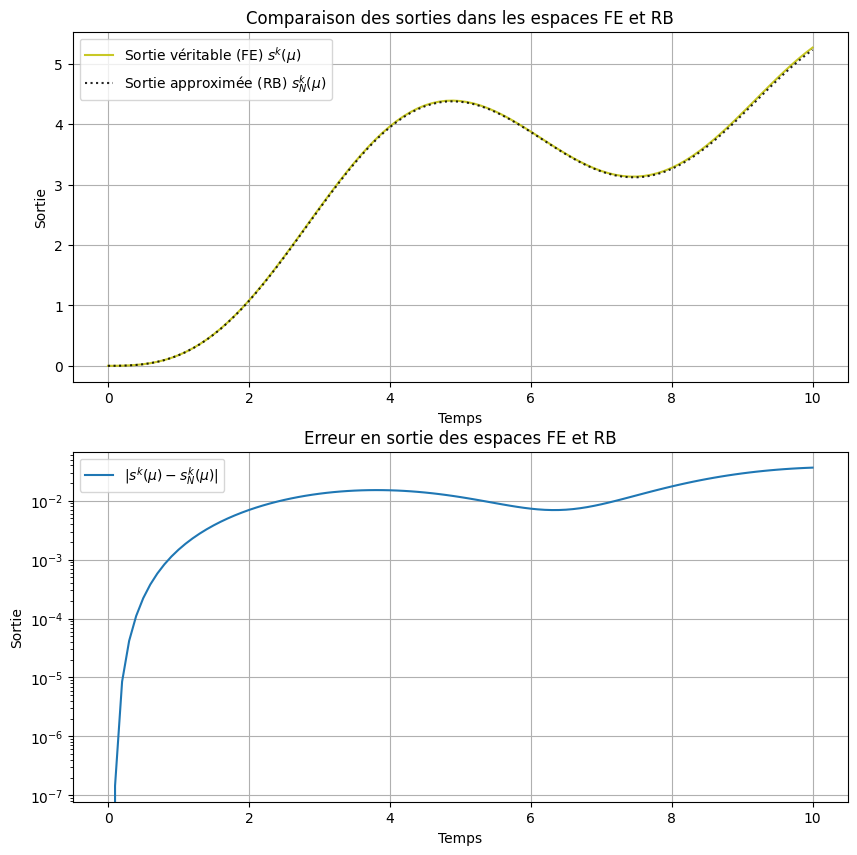

In [10]:
times = np.linspace(0, tMax, K+1)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(times, outputsFE, "y", label="Sortie véritable (FE) $s^k(\mu)$", alpha=0.85)
ax[0].plot(times, outputsRB, "k:", label="Sortie approximée (RB) $s^k_N(\mu)$", alpha=0.85)

ax[0].set_xlabel("Temps")
ax[0].set_ylabel("Sortie")
ax[0].set_title("Comparaison des sorties dans les espaces FE et RB")
ax[0].legend()
ax[0].grid()

ax[1].semilogy(times, outputErrors, label="$\\vert s^k(\mu) - s^k_N(\mu) \\vert$")
ax[1].set_xlabel("Temps")
ax[1].set_ylabel("Sortie")
ax[1].set_title("Erreur en sortie des espaces FE et RB")
ax[1].legend()
ax[1].grid()


* **Tracez $|\!|\!| u^k(\mu) |\!|\!|,\; |\!|\!| u^k_N(\mu) |\!|\!|$ et l'erreur $|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|$ en fonction du temps pour $g(t^k) = 1 - cos(t^k)$ et $\mu = 0,05$.**

On suit les mêmes étapes qu'avant, puis on utilise la norme d'énergie spatio-temporelle pour calculer les quantités souhaitées (rappel : $m$ est indépendant des paramètres).
$$
|\!|\!| w^k(\mu) |\!|\!| = \sqrt{m(w^k, w^k) + \sum_{k'=1}^k \Delta t \, a(w^{k'}, w^{k'}; \mu)}
$$

In [11]:
def energyNorm(WList, Mh, Ah, dt, k):
  '''
  Calcule la norme d'énergie spatio-temporelle
  '''
  sum = 0
  eNList = []
  for Wk_ in WList.T[:k]:
    sum += inner(Wk_, Wk_, Ah)
    eNList.append(np.sqrt(inner(Wk_, Wk_, Mh) + dt * sum))
  
  return np.array(eNList)

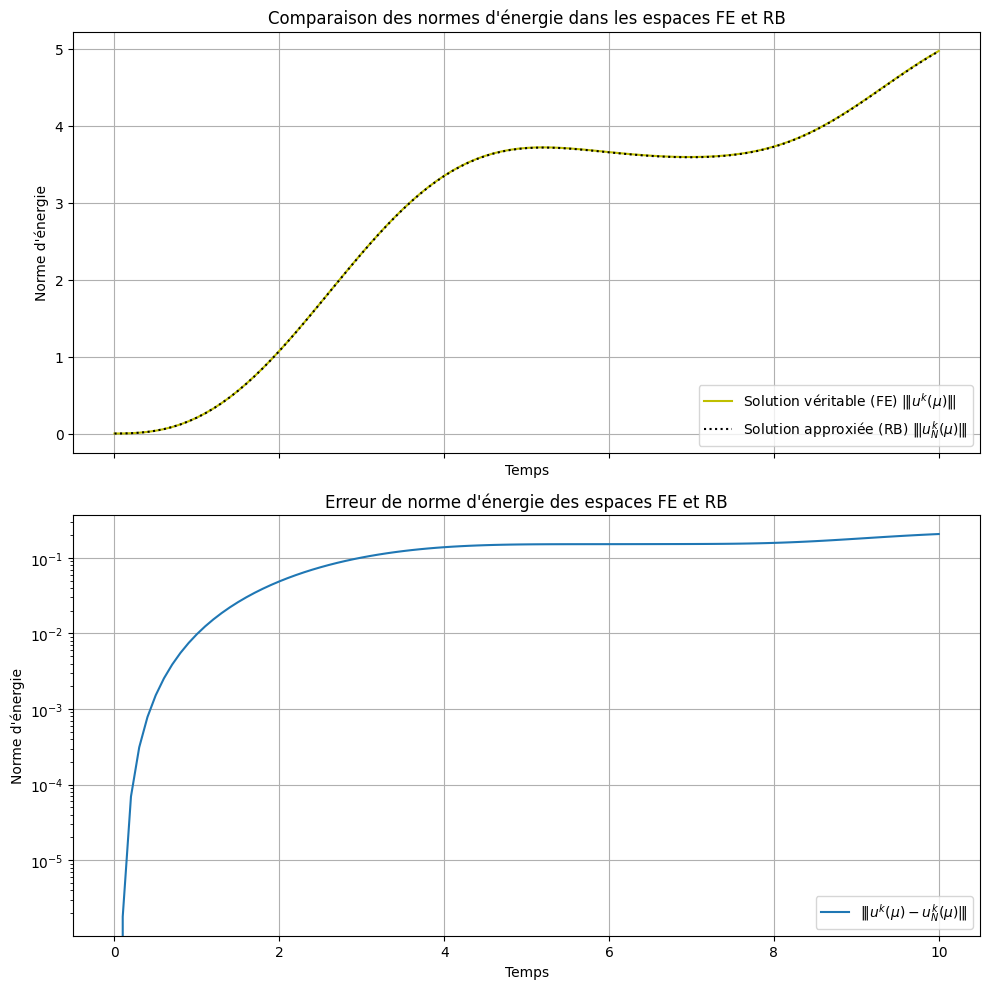

In [12]:
mu = buildMu(0.05)
Ah = assembleA(mu, Ahq)
ZUn = Zfull @ UnList

enNormsFE = energyNorm(UhList, Mh, Ah, dt, K+1)
enNormsRB = energyNorm(ZUn, Mh, Ah, dt, K+1)
enNormErrors = energyNorm(UhList - ZUn, Mh, Ah, dt, K+1)

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].plot(times, enNormsFE, 'y',
           label="Solution véritable (FE) $|\!|\!|u^k(\mu)|\!|\!|$")
ax[0].plot(times, enNormsRB, 'k:',
           label="Solution approxiée (RB) $|\!|\!|u^k_N(\mu)|\!|\!|$")
ax[0].set_xlabel("Temps")
ax[0].set_ylabel("Norme d'énergie")
ax[0].set_title("Comparaison des normes d'énergie dans les espaces FE et RB")
ax[0].legend(loc=4)
ax[0].grid()
ax[1].semilogy(times, enNormErrors, label="$|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|$")
ax[1].set_xlabel("Temps")
ax[1].set_ylabel("Norme d'énergie")
ax[1].set_title("Erreur de norme d'énergie des espaces FE et RB")
ax[1].legend(loc=4)
ax[1].grid()
plt.tight_layout();

## Partie 2 - Estimation de l'erreur a posteriori

* **Version hors-ligne/en-ligne pour la borne d'erreur a posteriori**

L'objectif est de dériver et d'implémenter une version hors ligne pour le calcul de la borne d'erreur de la norme d'énergie.

Le calcul de la borne d'erreur repose sur le calcul de la représentation de Riesz pour le résidu $r^k$.  
Pour tout $v \in X$, 
\begin{align*}
    (\hat e^k(\mu), v)_X &= r^k (v; \mu) \\
        &= f(v)g(t^k) - m\left( \frac{u^k_N(\mu) - u^{k-1}_N(\mu)}{\Delta t}, v \right) - a(u^k_N(\mu), v; \mu)
\end{align*}
Après avoir exprimé la solution dans la base RB $X_N = \mathrm{span}\{\xi_1, \ldots \xi_N\}$, on obtient
$$
    (\hat e^k(\mu), v)_X = f(v)g(t^k) - \sum_{n=1}^N \frac{u^k_{N, n}(\mu) - u^{k-1}_{N, n}(\mu)}{\Delta t} m\left(\xi_n , v \right) - \sum_{q=1}^{Q} \sum_{n=1}^N u^k_{N, n}(\mu)\, \theta^q(\mu) \, a^q(\xi_n, v)
$$
Par commodité, ***on abandonne la dépendance en $\mu$ dans nos notations***.  
En posant $w^k_N = \dfrac{u^k_N - u^{k-1}_N}{\Delta t} $, nous pouvons utiliser le principe de superposition pour exprimer $\hat e^k$ comme suit
$$
    \hat e^k = g(t^k)C + \sum_{n=1}^N w^k_{N, n} R_n + \sum_{q=1}^{Q} \sum_{n=1}^N u^k_{N, n} \, \theta^q \, L^q_n
$$
où les vecteurs $C, R_n$, et $L_n^q$ sont calculés en résolvant les équations
\begin{align*}
    \bar{A}_{\mathcal N}C &= F_{\mathcal N} \\
    \bar{A}_{\mathcal N}R_n &= - M_{\mathcal N} (Z^T)_n \\
    \bar{A}_{\mathcal N}L_n^q &= - A^q_{\mathcal N} (Z^T)_n
\end{align*}
où $(Z^T)_n$ est la $n$-ième colonne de la matrice RB $Z$.  
Pour calculer la norme de la représentation de Riesz, on effectue le produit
\begin{align*}
    (\hat e^k, \hat e^k)_X = g(t^k)^2 \underbrace{(C,C)_X}_{\mathrm{CC}} &+ 2 g(t^k) \sum_{n=1}^N w^k_{N,n} \underbrace{(C,R_n)_X}_{\mathrm{CR}_n} + 2 g(t^k) \sum_{q=1}^{Q} \sum_{n=1}^N u^k_{N,n} \theta^q \underbrace{(C,L^q_n)_X}_{\mathrm{CL}_n^q} \\
        &+ 2 \sum_{q=1}^{Q} \sum_{n=1}^N \sum_{n'=1}^{N} \theta^q w^k_{N,n} u^k_{N,n'} \underbrace{(R_n,L^q_{n'})_X}_{\mathrm{RL}_{n,n'}^q} + \sum_{n=1}^N \sum_{n'=1}^{N'} w^k_{N,n} \, w^k_{N,n'} \underbrace{(R_n,R_{n'})_X}_{\mathrm{RR}_{n, n'}} \\
        &+ \sum_{q=1}^{Q} \sum_{q'=1}^{Q} \sum_{n=1}^N \sum_{n'=1}^{N} \theta^q \theta^{q'} u^k_{N,n} u^k_{N,n'} \underbrace{(L_n^q,L^{q'}_{n'})_X}_{\mathrm{LL}^{q, q'}_{n, n'}}
\end{align*}
En utilisant les produits internes, cette formule peut être réécrite
\begin{align*}
    (\hat e^k, \hat e^k)_X  = g(t^k)^2 (\mathrm{CC}) &+ 2 g(t^k) (w^k)^T(\mathrm{CR}) + 2 g(t^k) \sum_{q=1}^Q \theta^q (u^k_N)^T (\mathrm{CL}^q) \\ 
        &+ 2\sum_{q=1}^Q \theta^q (w^k_N)^T (\mathrm{RL}^q) (u^k_{N}) + (w^k)^T (\mathrm{RR}) (w^k) \\
        &+  \sum_{q=1}^Q \sum_{q'=1}^Q \theta^q \theta^{q'} (u^k_N)^T (\mathrm{LL}^{q,q'}) (u^k_{N})
\end{align*}
$\mathrm{CC}$, $\mathrm{CR}$, $\mathrm{CL}^q$, $\mathrm{RL}^q$, $\mathrm{RR}$, et $\mathrm{LL}^{q, q'}$ sont toutes calculées et stockées hors-ligne, et les autres quantités dépendent des paramètres et sont donc calculées en-ligne.  
Pendant l'étape en-ligne, on effectue les produits scalaires indiqués et additionne les résultats de manière appropriée.  
Finalement, la racine carrée du résultat donne la norme X souhaitée de la représentation de Riesz.
$$
    \Vert \hat e^k(\mu) \Vert_X = \sqrt{(\hat e^k(\mu), \hat e^k(\mu))_X}
$$
Toujours en-ligne, on utilise la formule suivante pour calculer la borne d'erreur de la norme d'énergie
$$
    \Delta_N^k(\mu) = \alpha_{LB}^{-1/2}(\mu) \left( \sum_{k'=1}^k \Delta t \Vert \hat e^{k'}(\mu) \Vert_X^2  \right) ^{1/2}
$$
où $\alpha_{LB}(\mu)$ est obtenu par une approche min-thêta.

In [13]:
def minTheta(mu):
    '''
    borne inférieure pour alpha en utilisant min-theta
    '''
    return min(1, 10*mu[-1])


def offRBRiesz(ABar, Aq, F, M, Z):
    '''
    Construit hors ligne les composantes nécessaires de la base réduite
    '''
    LU = splu(ABar)
    C = LU.solve(F)
    CC = C.T @ ABar @ C

    R = LU.solve(-M @ Z)
    CR = C.T @ ABar @ R
    RR = R.T @ ABar @ R

    L = [LU.solve(-A @ Z) for A in Aq]
    CL = np.array([C.T @ ABar @ l for l in L])
    RL = np.array([R.T @ ABar @ l for l in L])
    LL = np.array([[l.T @ ABar @ l_ for l_ in L] for l in L])

    return CC, CR, RR, CL, RL, LL


def FEeHatRieszNorm(mu, k, UnList, g, dt, Aq, F, M, ABar, Z, sqrt=True):
    '''
    Calcule la norme de la représentation de Riesz - PHASE HORS-LIGNE
    '''
    N = UnList.shape[0]
    Z_ = Z[:, :N]
    Uk = UnList[:, k]
    Wk = (Uk - UnList[:, k-1]) / dt
    A = assembleA(mu, Aq)

    Rmu = F * g[k] - M @ Z_ @ Wk - A @ Z_ @ Uk
    LU = splu(ABar)
    eHat = LU.solve(Rmu)

    if sqrt:
        return norm(eHat, ABar)
    return inner(eHat, eHat, ABar)


def RBeHatRieszNorm(mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL, sqrt=True):
    '''
    Calcule la norme de la représentation de Riesz - PHASE EN-LIGNE
    '''
    N, Uk = UnList.shape[0], UnList[:, k]
    Wk = (UnList[:, k] - UnList[:, k-1]) / dt

    eHatNorm = CC * g[k]**2 + 2 * g[k] * Wk.T @ CR[:N] + Wk.T @ RR[:N, :N] @ Wk
    for q in range(6):
        temp = 2 * Wk.T @ RL[q][:N, :N] @ Uk + 2 * g[k] * Uk.T @ CL[q][:N]
        for q_ in range(6):
            temp += mu[q_] * Uk.T @ LL[q, q_][:N, :N] @ Uk
        eHatNorm += mu[q] * temp
        
    if sqrt:
        return np.sqrt(abs(eHatNorm))
    return abs(eHatNorm)


def offOnErrBounds(mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL):
    '''
    Calcule la borne d'erreur - Méthode hors/en-ligne
    '''
    alphaLB = minTheta(mu)
    Delta = 0
    Bounds = []

    for k_ in range(1, k+1):
        eHatNorm = RBeHatRieszNorm(
            mu, k_, UnList, g, dt, CC, CR, RR, CL, RL, LL, False)
        Delta += eHatNorm
        Bounds.append(Delta)

    return np.sqrt(dt * np.array(Bounds) / alphaLB)

- Calcul des données hors-ligne

In [14]:
CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, Zfull)
print("CC", CC)
print("Forme de CR:", CR.shape)
print("Forme de RR:", RR.shape)
print("Forme de CL:", CL.shape)
print("Forme de RL:", RL.shape)
print("Forme de LL:", LL.shape)

CC 1.5987665270309712
Forme de CR: (10,)
Forme de RR: (10, 10)
Forme de CL: (6, 10)
Forme de RL: (6, 10, 10)
Forme de LL: (6, 6, 10, 10)


* Test définissant les paramètres de base pour le calcul de la représentation de Riesz

In [15]:
mu = buildMu(0.05)
k = 50

eHatNorm = RBeHatRieszNorm(mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL)
print("Test de la norme de Riesz pour k = %d:" % k, eHatNorm)

alphaLB = minTheta(mu)
print("Alpha_LB test:", alphaLB)

errBound = offOnErrBounds(
    mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL)[-1]
print("Test de la borne d'erreur Hors/En-ligne:", errBound)

Test de la norme de Riesz pour k = 50: 0.03727148656808
Alpha_LB test: 0.5
Test de la borne d'erreur Hors/En-ligne: 0.21243394881305872


- Calcul direct de la borne d'erreur
  
Le calcul direct est simple :
$$
(\hat e (\mu), v)_X = r(v;\mu)
$$ 
en utilisant $w^k_N(\mu) = \frac{u^k_N(\mu) - u^{k-1}_N(\mu)}{\Delta t} $, on obtient
$$
\bar A_{\cal N} \hat e (\mu) = F_{\cal N} g(t^k) - M_{\cal N}(Z w_N^k(\mu)) - A_{\cal N}(\mu)(Z u_N^k(\mu))
$$
Ici, la borne inférieure de la constante de coercivité sera calculée en résolvant un problème de valeur propre généralisé.  
Cependant, cette méthode est lente et, pour des raisons de performance, on peut utiliser l'approche min-thêta, beaucoup plus rapide.

In [16]:
def LBCoercivity(mu, Ahq, AhBar):
    '''
    Calcule les constantes de continuité et de coercivité en résolvant
        un problème de valeur propre généralisé
    '''
    Ah = assembleA(mu, Ahq)
    alphaLB = eigsh(Ah, M=AhBar, k=1, which='SM', return_eigenvectors=False)[0]
    return alphaLB


def directErrBounds(mu, k, UnList, g, dt, Ahq, Fh, Mh, AhBar, Z, eig=False):
    '''
    Calcule la borne d'erreur - Méthode directe
    '''
    if eig:
        alphaLB = LBCoercivity(mu, Ahq, AhBar)
    else:
        alphaLB = minTheta(mu)
    Delta = 0
    Bounds = []

    for k_ in range(1, k+1):
        eHatNorm = FEeHatRieszNorm(
            mu, k_, UnList, g, dt, Ahq, Fh, Mh, AhBar, Z, False)
        Delta += eHatNorm
        Bounds.append(Delta)

    return np.sqrt(dt * np.array(Bounds) / alphaLB)

* Test définissant les paramètres de base

In [17]:
eHatNorm = FEeHatRieszNorm(mu, k, UnList, g, dt, Ahq, Fh, Mh, AhBar, Zfull)
print("Test de la norme de Riesz pour k = %d :" % k, eHatNorm)

errBound = directErrBounds(mu, k, UnList, g, dt, Ahq, Fh, Mh, AhBar, Zfull)[-1]
print("Test de la borne d'erreur Hors/En-ligne :", errBound)

Test de la norme de Riesz pour k = 50 : 0.03727148656808177
Test de la borne d'erreur Hors/En-ligne : 0.21243394881271221


In [18]:
def printErrBounds(Z, title=None):
    '''
    Calcule et trace les erreurs d'énergie
    '''
    K = 100
    tMax = 10
    dt = tMax / K
    Anq, Fn, _, Mn = RBOffData(Z, Ahq, Fh, Lh, Mh)

    mu = buildMu(0.05)
    g = gCos(np.linspace(0, tMax, K+1))

    UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)
    UnList = computeSol(mu, Anq, Fn, Mn, g, dt)

    A = assembleA(mu, Ahq)
    dt = tMax / K

    UhZUn = UhList - Z @ UnList
    enNormErrors = energyNorm(UhZUn, Mh, A, dt, K+1)[1:]

    CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, Z)
    errBoundData = offOnErrBounds(mu, K, UnList, g, dt, CC, CR, RR, CL, RL, LL)
    errBoundData[0] = np.nan
    
    times = np.linspace(0, tMax, K+1)[1:]

    plt.figure(figsize=(10, 5))
    plt.semilogy(times, enNormErrors, "m",
                   label="Erreur de la norme d'énergie $|\!\Vert u^k(\mu) - u^k_N(\mu)|\!\Vert$")
    plt.semilogy(times, errBoundData, "y",
                   label="Borne d'erreur de la norme d'énergie $\\Delta_N^{k}(\mu)$")
    plt.xlabel("Temps")
    plt.ylabel("Borne d'erreur de la norme d'énergie")
    plt.title("Erreur et borne d'erreur de la norme d'énergie")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.suptitle(title)

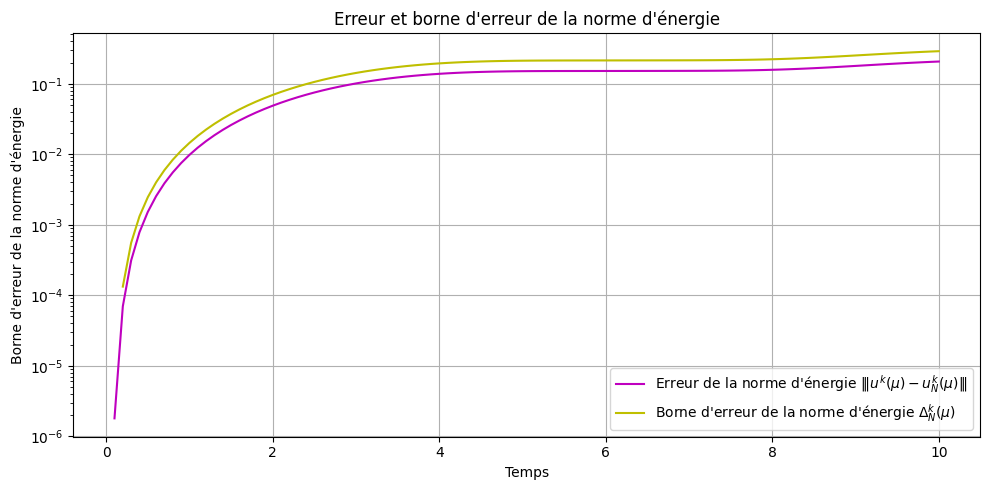

In [19]:
printErrBounds(Zfull)

* **Comparaison des deux méthodes dans le temps**

In [20]:
nTest = 10
nPlot = 5

Bis = logmu.rvs(size=nTest)
onOffData = np.zeros((nTest, nPlot+1))
directData = np.zeros((nTest, nPlot+1))

for i, Bi in enumerate(Bis):
    mu = buildMu(Bi)
    UnList = computeSol(mu, Anq, Fn, Mn, g, dt)
    offonErrBounds = offOnErrBounds(mu, K, UnList, g, dt, CC, CR, RR, CL, RL, LL)
    dirErrBounds = directErrBounds(mu, K, UnList, g, dt, Ahq, Fh, Mh, AhBar, Zfull)

    for j, k in enumerate(range(0, K+1, K//nPlot)):
        if k==0:
            onOffData[i, j] = offonErrBounds[k]
            directData[i, j] = dirErrBounds[k]
        else:
            onOffData[i, j] = offonErrBounds[k-1]
            directData[i, j] = dirErrBounds[k-1]

In [21]:
mask = list(np.arange(0, nPlot+1))
steps = np.arange(0, K+1, K//nPlot)
steps[0] = 1
title = "Décomposition Hors-ligne/En-Ligne decomposition"
df = pd.DataFrame({"Time step": steps})

for i, Bi in enumerate(Bis):
    df["mu = "+str(np.round(Bi, 3))] = onOffData[i][mask]
df.style.set_table_attributes(
    "style='display:inline'").set_caption(title)

,Time step,mu = 0.416,mu = 0.127,mu = 0.252,mu = 0.025,mu = 0.046,mu = 0.077,mu = 0.02,mu = 0.017,mu = 0.07,mu = 0.035
0,1,0.000024,0.000007,0.000014,0.000002,0.000003,0.000004,0.000001,0.000001,0.000004,0.000002
1,20,0.048875,0.048950,0.048771,0.098141,0.072513,0.055935,0.110400,0.118418,0.058555,0.082865
2,40,0.141366,0.137970,0.139244,0.274511,0.203086,0.156993,0.308708,0.331082,0.164265,0.231922
3,60,0.158604,0.152188,0.155073,0.302541,0.223715,0.172930,0.340365,0.365138,0.180936,0.255514
4,80,0.162969,0.156336,0.159411,0.323702,0.233096,0.178182,0.368878,0.398827,0.186662,0.268926
5,100,0.207204,0.198308,0.202686,0.445637,0.305028,0.227369,0.518792,0.567809,0.238873,0.359235


In [22]:
title = "Calcul direct"
df = pd.DataFrame({"Pas de temps": steps})

for i, Bi in enumerate(Bis):
    df["mu = "+str(np.round(Bi, 3))] = directData[i][mask]
df.style.set_table_attributes(
    "style='display:inline'").set_caption(title)

,Pas de temps,mu = 0.416,mu = 0.127,mu = 0.252,mu = 0.025,mu = 0.046,mu = 0.077,mu = 0.02,mu = 0.017,mu = 0.07,mu = 0.035
0,1,0.000024,0.000007,0.000014,0.000002,0.000003,0.000004,0.000001,0.000001,0.000004,0.000002
1,20,0.048875,0.048950,0.048771,0.098141,0.072513,0.055935,0.110400,0.118418,0.058555,0.082865
2,40,0.141366,0.137970,0.139244,0.274511,0.203086,0.156993,0.308708,0.331082,0.164265,0.231922
3,60,0.158604,0.152188,0.155073,0.302541,0.223715,0.172930,0.340365,0.365138,0.180936,0.255514
4,80,0.162969,0.156336,0.159411,0.323702,0.233096,0.178182,0.368878,0.398827,0.186662,0.268926
5,100,0.207204,0.198308,0.202686,0.445637,0.305028,0.227369,0.518792,0.567809,0.238873,0.359235


Les tableaux montrent que les deux méthodes donnent les mêmes résultats.  
Traçons ces résultats.

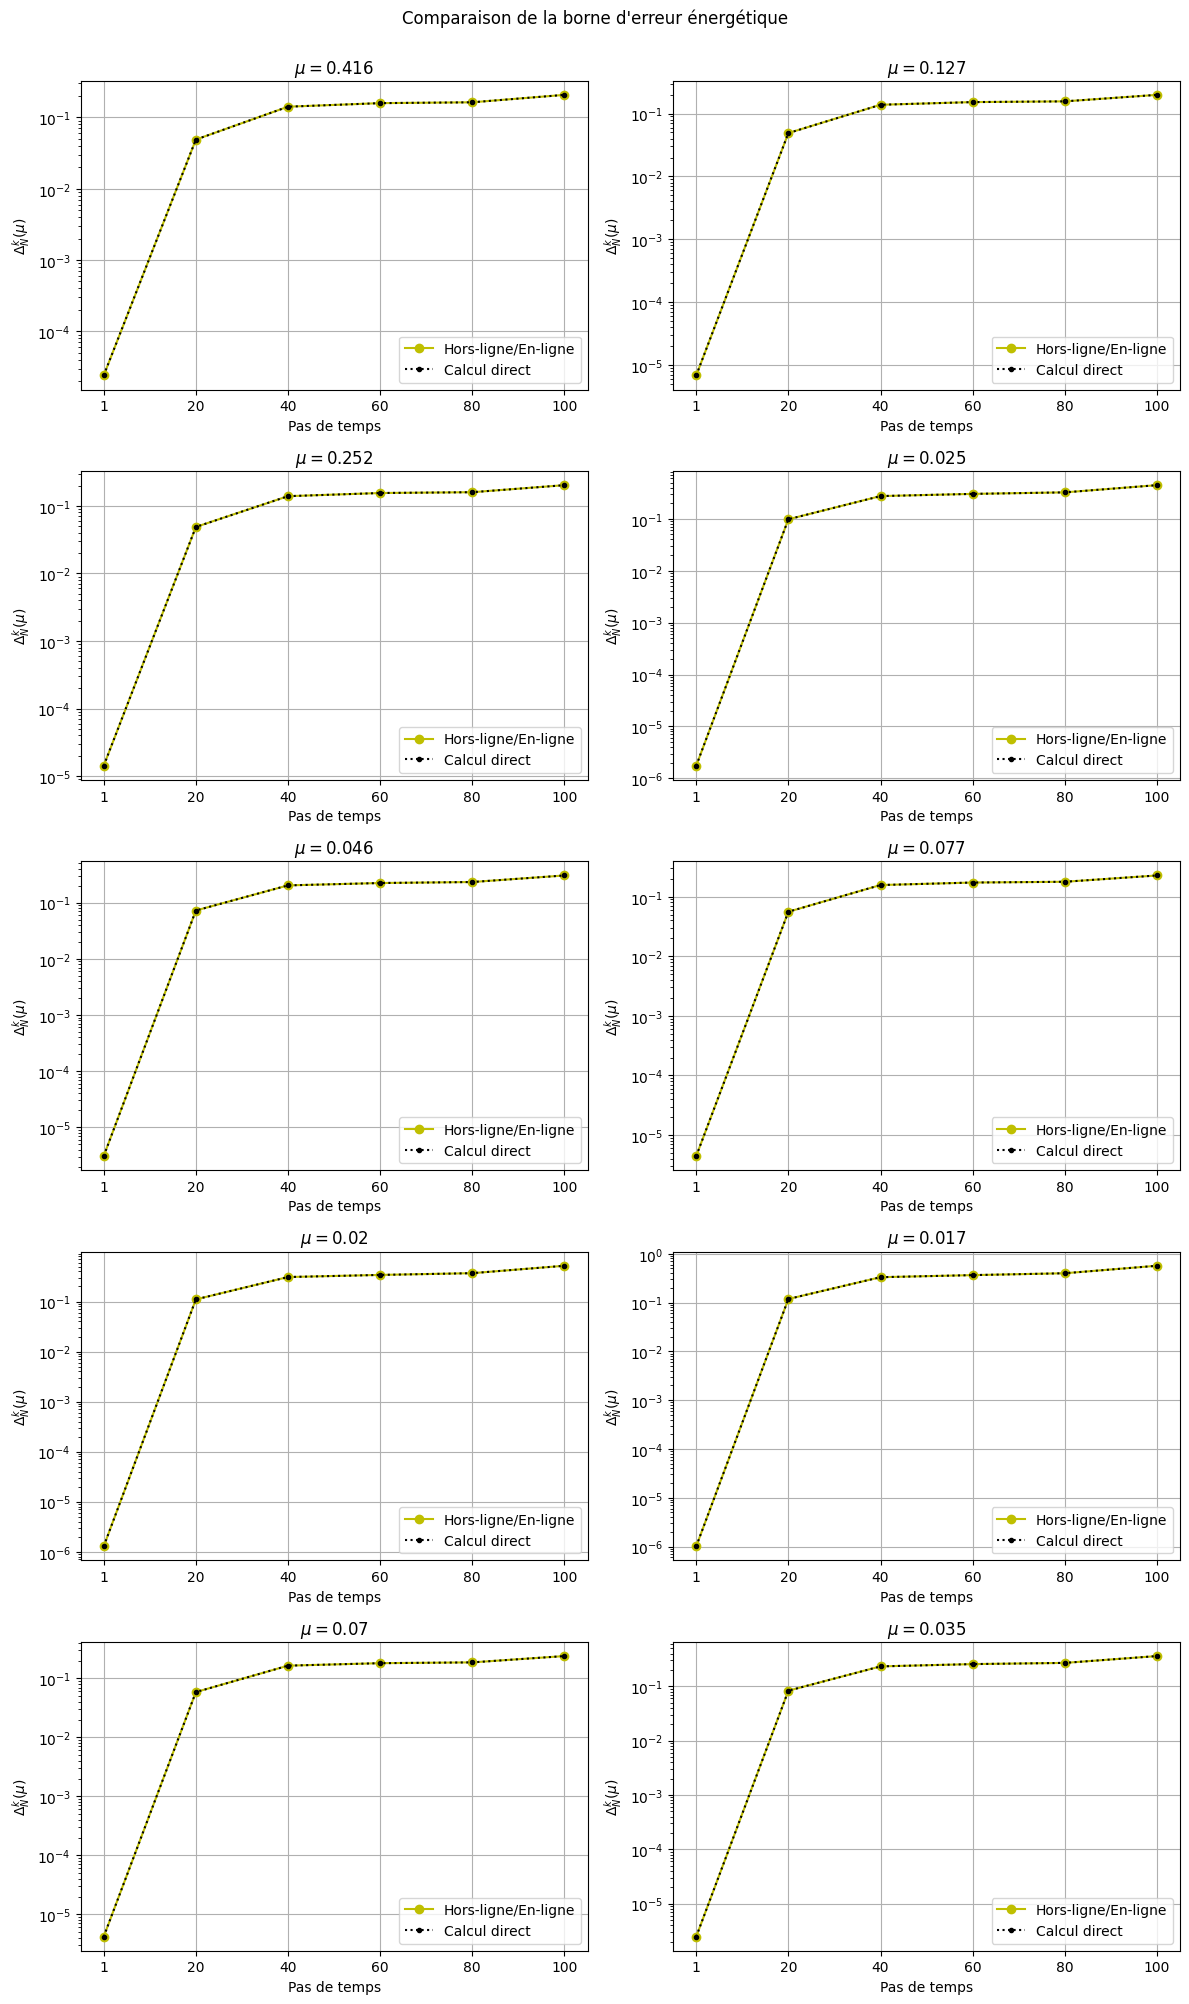

In [23]:
ticks = list(np.arange(0, nPlot+1))
ticklabels = list(np.arange(0, K+1, K//nPlot))
ticklabels[0] = 1

fig, ax = plt.subplots(nTest//2, 2, figsize=(12, 2*nTest))
for i, Bi in enumerate(Bis):
    temp = ax[i // 2, i % 2]
    temp.semilogy(onOffData[i], "yo-", label="Hors-ligne/En-ligne")
    temp.semilogy(directData[i], "k.:", label="Calcul direct")
    temp.set_xlabel("Pas de temps")
    temp.set_xticks(ticks)
    temp.set_xticklabels(ticklabels)
    temp.set_ylabel("$\Delta_N^{k}(\mu)$")
    temp.set_title("$\\mu=$"+str(np.round(Bi, 3)))
    temp.legend()
    temp.grid()
plt.suptitle("Comparaison de la borne d'erreur énergétique", y=1)
plt.tight_layout();

Les résultats sont exactement les mêmes.

* **Borne d'erreur en sortie a posteriori *hors-ligne/en-ligne***  

Ici, l'objectif est de dériver et d'implémenter une version hors ligne et en ligne de la borne d'erreur a posteriori pour la variable de la sortie $s$.  
On utilise la formule
$$
\Delta_N ^{s,k} = \sigma_{LB}^{-1} \left( \sup_{v\in X} \frac{l(v;\mu)}{\Vert v \Vert} \right) \Delta_N^k(\mu)
$$
1. On calcule la norme de la représentation de Riesz pour la fonction linéaire de la sortie $\hat l (\mu)= \sup_{v\in X} \frac{l(v;\mu)}{\Vert v \Vert}$. Cela se fait hors ligne en résolvant
$$
\bar A_{\cal N} \hat l(\mu) = L_{\cal N}
$$
2. On utilise la décomposition hors-ligne/en-ligne pour calculer la borne d'erreur de la norme d'énergie $\Delta_N^k(\mu)$ en utilisant les fonctions de la section précédente.
3. La constante de coercivité $\sigma_{LB}$ de $m$ vaut $1$, selon la définition de la norme $L^2$, et la forme bilinéaire $m(\cdot, \cdot)$ est indépendante du paramètre,  
c'est-à-dire $$m(u,v;\mu) = m(u,v;\bar \mu) = m(u,v),$$et  le problème de valeurs propres généralisé $$Mv = \lambda \bar{M}v  \Longrightarrow  (1-\lambda) v = 0$$ a comme valeur propre unique $1$.

Ces trois éléments (calculés indépendamment) montrent que le calcul de la borne d'erreur en sortie mélange le calcul hors-ligne/en-ligne et le calcul direct.

In [24]:
def sigmaCoercivity(Mh, MhBar):
    '''
    Calcule sigma_LB
    '''
    sigmaLB = eigsh(Mh, M=MhBar, k=1, which='SM', return_eigenvectors=False)[0]
    return sigmaLB

In [25]:
def lHatRieszNorm(ABar, L):
    '''
    Calcule la norme de ^l
    '''
    LU = splu(ABar)
    lHat = LU.solve(L)
    return norm(lHat, ABar)

lHatNorm = lHatRieszNorm(AhBar, Lh)

In [26]:
def outputErrBounds(mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL, lHatNorm):
    '''
    Calcule la borne d'erreur de la sortie
    '''
    alphaLB = minTheta(mu)
    sigmaLB = sigmaCoercivity(Mh, Mh)
    Delta = 0
    Bounds = []
    
    for k_ in range(1, k+1):
        eHatNorm = RBeHatRieszNorm(mu, k_, UnList, g, dt, CC, CR, RR, CL, RL, LL, False)
        Delta += eHatNorm
        Bounds.append(Delta)
    Bounds = np.sqrt(dt * np.array(Bounds) / alphaLB)

    return lHatNorm * Bounds / sigmaLB

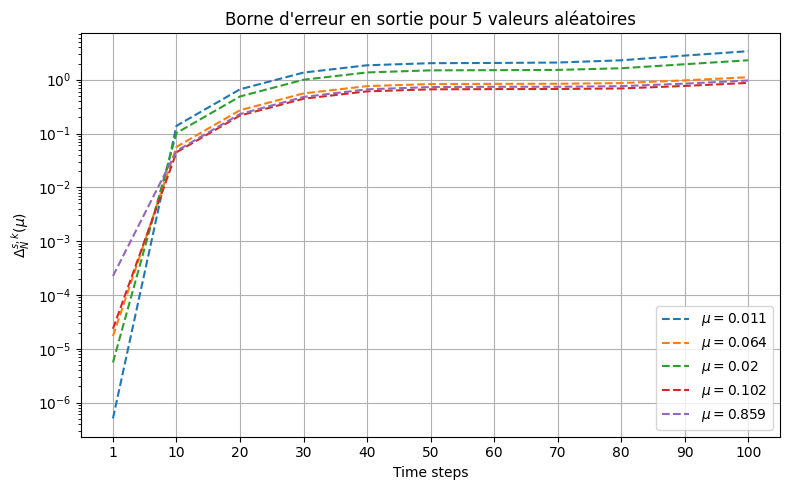

In [27]:
nTest = 5
nPlot = 10

Bis = logmu.rvs(size=nTest)
onOffOutData = np.zeros((nTest, nPlot+1))
ticks = list(np.arange(0, nPlot+1))
ticklabels = list(np.arange(0, K+1, K//nPlot))
ticklabels[0] = 1

for i, Bi in enumerate(Bis):
    mu = buildMu(Bi)
    UnList = computeSol(mu, Anq, Fn, Mn, g, dt)
    outerrBounds = outputErrBounds(mu, K, UnList, g, dt, CC, CR, RR, CL, RL, LL, lHatNorm)

    for j, k in enumerate(range(0, K+1, K//nPlot)):
        if k == 0:
            onOffOutData[i, j] = outerrBounds[0]
        else:
            onOffOutData[i, j] = outerrBounds[k-1]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, Bi in enumerate(Bis):
    lbl = "$\\mu=$"+str(np.round(Bi, 3))
    ax.semilogy(onOffOutData[i], "--", label=lbl)
ax.set_xlabel("Time steps")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_ylabel("$\Delta_N^{s, k}(\mu)$")
ax.set_title("Borne d'erreur en sortie pour 5 valeurs aléatoires")
ax.legend()
ax.grid()
plt.tight_layout();

## Partie 3 - Procédure d'échantillonnage

L'algorithme $\small\mathrm{POD}(t)-\mathrm{Greedy}(\mu)$ est un algorithme efficace pour construire un échantillon RB optimal.  
Les détails de l'algorithme $\small\mathrm{POD}(t)$ sont expliqués dans les notes de cours de ce cours. Ses principales étapes sont :
1. Former une matrice de corrélation
$$
C^{POD}_{i,j} = \frac{1}{K} (u^i(\mu), u^j(\mu))_X, \, \, 1 \leq i, j \leq K
$$
2. Calculer le couple propre correspondant à la plus grande valeur propre $\lambda^{POD, max}$ à partir de
$$
C^{POD} \phi^{POD, k} =  \lambda^{POD, k} \phi^{POD, k}
$$
3. Calculer le plus grand mode POD (qui sera ajouté à la base RB en construction) 
$$
\Phi^{POD, 1} = \sum_{k=1}^K \phi^{POD, max}_k u^k(\mu)
$$

Ensuite, on peut passer à l'étape $\small\mathrm{Greedy}(\mu)$.

In [28]:
def projectGroup(v, u, A):
    '''
    Projette une liste de vecteurs (v) sur u en utilisant le produit associé à A
    '''
    return inner(u, v, A) * u[:, np.newaxis] / inner(u, u, A)

def GramSchmidt(Z, u, A):
    '''
    Algorithme de Gram-Schmidt
    '''
    z = u

    if Z.shape[1] > 0 and len(Z) > 0:
        for zk in Z.T:
            z -= projectGroup(u, zk, A)

    return z

def buildCorrelationMatrix(UkListProj, AhBar):
    '''
    Forme la matrice de corrélation
    '''
    K = UkListProj.shape[1]
    C = np.zeros((K, K))

    for i in range(K):
        C[i, i] = UkListProj[:, i].T @ AhBar @ UkListProj[:, i]
        for j in range(i+1, K):
            C[i, j] = UkListProj[:, i].T @ AhBar @ UkListProj[:, j]
            C[j, i] = C[i, j]

    return C / K

def performPOD(UkListProj, AhBar):
    '''
    Trouve et utilise le mode POD le plus important
    '''
    C = buildCorrelationMatrix(UkListProj, AhBar)
    modVec = np.real(eigsh(C, k=1, which="LM")[1])

    K = C.shape[0]
    NCal = UkListProj.shape[0]
    Upod = np.zeros((NCal))
    
    for i in range(K):
        Upod += modVec[i] * UkListProj[:, i]
    
    return Upod

In [29]:
def maxDeltaGreedy(sample, Z, Ahq, Fh, Lh, Mh, AhBar, g, dt):
    '''
    Calcule le Delta max. relatif sur un échantillon
    '''
    Anq, Fn, _, Mn = RBOffData(Z, Ahq, Fh, Lh, Mh)
    CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, Z)

    DeltaMaxRel = -1
    muOpt = None
    K_ = len(g) - 1
    
    for Bi in sample:
        mu = buildMu(Bi)
        UnList = computeSol(mu, Anq, Fn, Mn, g, dt)
        Ah = assembleA(mu, Ahq)
        UnKnorm = energyNorm(Z @ UnList, Mh, Ah, dt, K_)[-1]
        DeltaMax = offOnErrBounds(
            mu, K, UnList, g, dt, CC, CR, RR, CL, RL, LL)[-1]
        DeltaRel = np.sum(DeltaMax) / UnKnorm

        if DeltaRel > DeltaMaxRel:
            DeltaMaxRel = DeltaRel
            muOpt = mu

    return DeltaMaxRel, muOpt

In [30]:
def greedyPODSampling(trainSample, Ahq, Fh, Lh, Mh, AhBar, tMax, K, mu0, tol):
    greedySample = []  # Échantillons RB
    DeltaMaxRel = []
    Z = np.array([])  # Base RB en construction
    Z = Z[:, np.newaxis]
    g = gKnk(np.linspace(0, tMax, K+1))
    dt = tMax / K
    mu = mu0
    N = len(trainSample)
    temp = np.inf

    print("Bornes d'erreur relative")
    for i in range(N):
        # Calcule la solution exacte
        UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)

        # Projette la solution sur l'espace courant
        UhListProj = GramSchmidt(Z, UhList, AhBar)

        # Exécute l'algorithme POD dans le temps
        Upod = performPOD(UhListProj, AhBar)
        Upod = Upod / norm(Upod, AhBar)

        # Ajoute un vecteur à la base courante
        Upod = Upod[:, np.newaxis]
        if i == 0:
            Z = np.concatenate([Z, Upod])
        else:
            Z = np.concatenate([Z, Upod], axis=1)

        # Ajoute un paramètre à l'échantillon courant
        greedySample.append(mu[-1])

        # Cherche le prochain paramètre optimal
        err, mu = maxDeltaGreedy(trainSample, Z, Ahq, Fh, Lh, Mh, AhBar, g, dt)
        trainSample = np.setdiff1d(trainSample, mu[-1])

        # Ajoute la nouvelle erreur à la liste
        DeltaMaxRel.append(err)

        if err < tol:
            print("-- Étape", i+1, ":", err)
            break

        if err < temp / 2:
            print("-- Étape", i+1, ":", err)
            temp = err

    return Z, greedySample, DeltaMaxRel

- Test de l'algorithme POD-Greedy.

In [31]:
%%time
nTrain = 100
trainSample = np.logspace(-2, 0, nTrain)[1:]
tMax = 10
K = 100

ZGreedy, greedySample, DeltaMaxRel = greedyPODSampling(
    trainSample, Ahq, Fh, Lh, Mh, AhBar, tMax, K, buildMu(0.01), 1e-6)

Bornes d'erreur relative


-- Étape 1 : 6.1178734364106635
-- Étape 2 : 2.8296683671937197
-- Étape 3 : 1.094815028617707
-- Étape 4 : 0.4197374834772769
-- Étape 5 : 0.2060531406185708
-- Étape 7 : 0.08728955234729319
-- Étape 9 : 0.03522976075915476
-- Étape 12 : 0.012781761829316287
-- Étape 14 : 0.005021150614215897
-- Étape 16 : 0.0022971440971220245
-- Étape 18 : 0.0009008201859038703
-- Étape 22 : 0.0003308352613124325
-- Étape 24 : 0.00015083485341023636
-- Étape 27 : 6.579261258794712e-05
-- Étape 30 : 2.3622683971267165e-05
-- Étape 33 : 1.1538636879893226e-05
-- Étape 36 : 4.13216555069793e-06
-- Étape 39 : 1.927159058710811e-06
-- Étape 42 : 7.700973482777628e-07
CPU times: total: 14.5 s
Wall time: 1min 15s


* **Valeur de $N_{max}$ pour obtenir la précision souhaitée, et tracés.**

In [32]:
print()
print('Forme de la matrice RB :', ZGreedy.shape)
print('Échantillon RB :', greedySample)

np.save("Échantillon Greedy", np.array(greedySample))
np.save("Z Greedy", ZGreedy)
np.save("DeltaMaxRel", DeltaMaxRel)


Forme de la matrice RB : (4760, 42)
Échantillon RB : [0.01, 0.010476157527896646, 0.010974987654930561, 0.011497569953977356, 0.012045035402587823, 1.0, 0.012618568830660204, 0.9545484566618342, 0.013219411484660288, 0.2848035868435802, 0.9111627561154896, 0.013848863713938732, 0.03678379771828634, 0.014508287784959394, 0.43287612810830595, 0.8697490026177834, 0.01519911082952934, 0.22570197196339203, 0.6280291441834256, 0.044306214575838825, 0.015922827933410922, 0.5994842503189411, 0.8302175681319748, 0.14174741629268056, 0.4750810162102798, 0.02420128264794382, 0.016681005372000592, 0.7924828983539177, 0.15556761439304723, 0.4534878508128584, 0.01747528400007684, 0.7564633275546291, 0.07390722033525779, 0.41320124001153385, 0.13530477745798075, 0.04229242874389499, 0.327454916287773, 0.7220809018385468, 0.01830738280295368, 0.35938136638046275, 0.019179102616724886, 0.23644894126454083]


Comme l'indiquent les résultats ci-dessus, la valeur requise de $N_{max}$ pour obtenir une précision inférieure à $1e-6$ est de $42$.

- Traçons $ \Delta_N^{max} = \frac{\Delta_N^k(\mu*)}{|\!|\!|u^k(\mu*)|\!|}$ en fonction de $N$. 

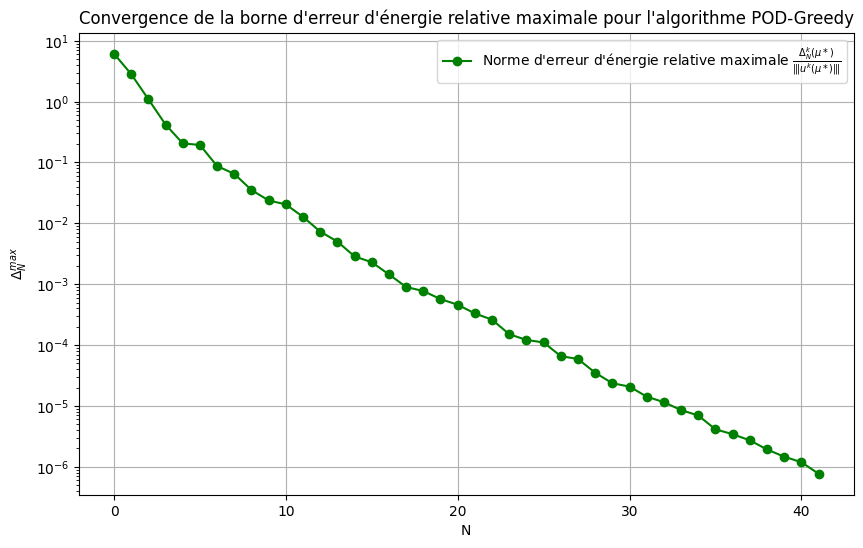

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(DeltaMaxRel, "go-",
        label="Norme d'erreur d'énergie relative maximale $\\frac{\Delta_N^k(\mu*)}{|\!|\!|u^k(\mu*)|\!|\!|}$")
ax.set_xlabel("N")
ax.set_ylabel("$\\Delta_N^{max}$")
ax.set_yscale("log")
ax.set_title(
    "Convergence de la borne d'erreur d'énergie relative maximale pour l'algorithme POD-Greedy")
ax.legend()
ax.grid();

- Tracés des sorties

In [34]:
def testOutput(Z, title=None):
    K = 100
    tMax = 10
    dt = tMax / K
    Anq, Fn, Ln, Mn = RBOffData(Z, Ahq, Fh, Lh, Mh)
    mu = buildMu(0.05)
    g = gCos(np.linspace(0, tMax, K+1))

    UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)
    UnList = computeSol(mu, Anq, Fn, Mn, g, dt)

    outputsFE = np.array([computeOutput(Lh, Uh) for Uh in UhList.T])
    outputsRB = np.array([computeOutput(Ln, Un) for Un in UnList.T])   
    outputErrors = np.abs(outputsFE - outputsRB)

    CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, Z)

    onOffOutData = outputErrBounds(mu, K, UnList, g, dt, CC, CR, RR, CL, RL, LL, lHatNorm)

    times = np.linspace(0, tMax, K+1)

    _, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(times, outputsFE, "y", label="Sortie véritable $s^k(\mu)$", alpha=0.85)
    ax[0].plot(times, outputsRB, "k:", label="Sortie approximée $s^k_N(\mu)$", alpha=0.85)
    ax[0].set_xlabel("Temps")
    ax[0].set_ylabel("Sortie")
    ax[0].set_title("Comparaison des sorties dans les espaces FE et RB")
    ax[0].legend()

    ax[1].semilogy(times, outputErrors, "m",
                   label="Erreur en sortie $\\vert s^k(\mu) - s^k_N(\mu) \\vert$")
    ax[1].semilogy(times[1:], onOffOutData, "y",
                   label="Borne d'erreur en sortie $\\Delta_N^{k,s}(\mu)$")
    ax[1].set_xlabel("Temps")
    ax[1].set_ylabel("Erreur en sortie")
    ax[1].set_title("Erreur et borne d'erreur en sortie")
    ax[1].legend()

    plt.suptitle(title)

##### $N=10$

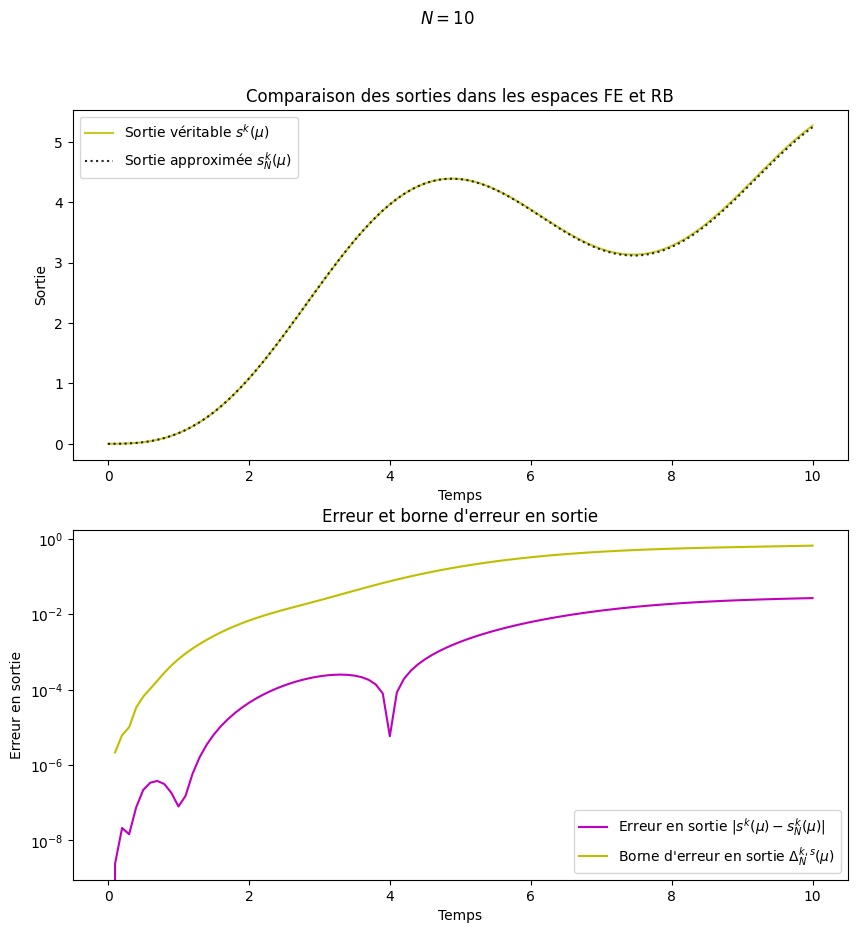

In [35]:
N = 10
Z = ZGreedy[:, :N]

testOutput(Z, title="$N=10$")

Les résultats obtenus ici sont meilleurs que ceux obtenus à la partie 1, où $N=10$. 

##### $N=N_{max}$

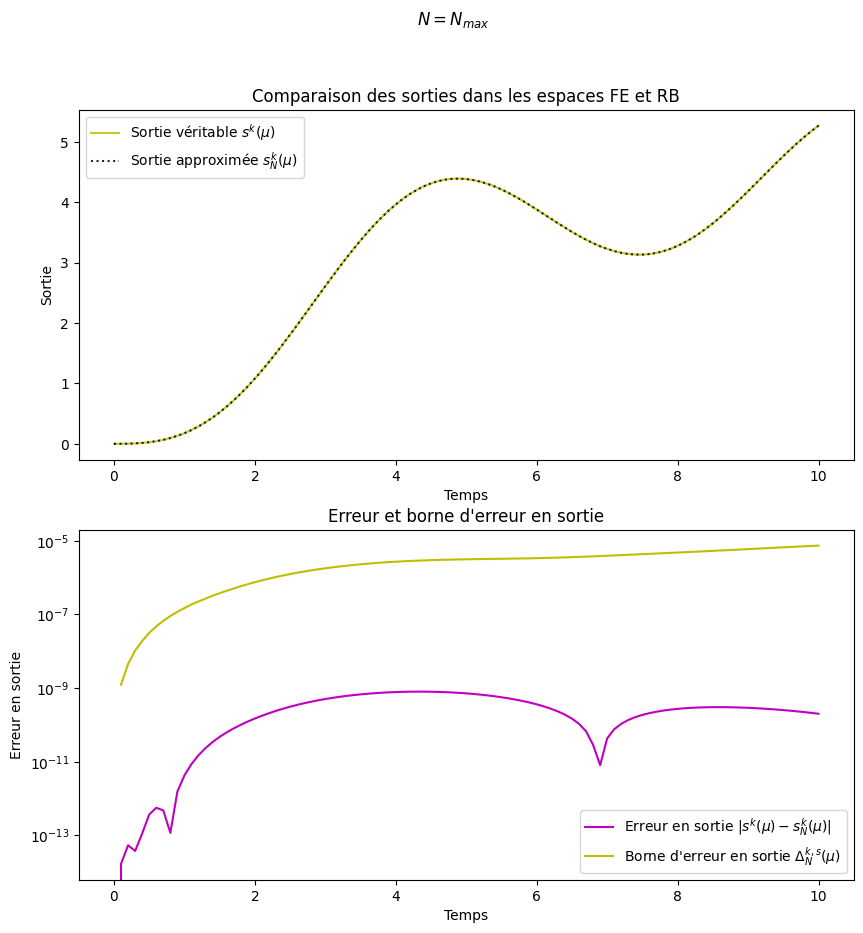

In [36]:
testOutput(ZGreedy, title="$N=N_{max}$")

Augmenter la valeur de $N$ améliore l'approximation.
On voit que l'erreur de la sortie est nettement plus petite par rapport au cas précédent ($N=10$). L'implémentation semble correcte.

- **Tracé des variables de champ**

In [37]:
def testErrors(Z, title=None):
    '''
    Calcule et trace les erreurs d'énergie
    '''
    K = 100
    tMax = 10
    dt = tMax / K
    Anq, Fn, _, Mn = RBOffData(Z, Ahq, Fh, Lh, Mh)

    mu = buildMu(0.05)
    g = gCos(np.linspace(0, tMax, K+1))

    UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)
    UnList = computeSol(mu, Anq, Fn, Mn, g, dt)

    A = assembleA(mu, Ahq)
    dt = tMax / K

    ZUn = Z @ UnList
    UhZUn = UhList - Z @ UnList
    enNormsFE = energyNorm(UhList, Mh, A, dt, K+1)
    enNormsRB = energyNorm(ZUn, Mh, A, dt, K+1)
    enNormErrors = energyNorm(UhZUn, Mh, A, dt, K+1)

    CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, Z)
    errBoundData = offOnErrBounds(mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL)

    times = np.linspace(0, tMax, K+1)

    _, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].semilogy(times, enNormsFE, "y",
                   label="Solution véritable $|\!\Vert u^k(\mu)|\!\Vert$", alpha=0.85)
    ax[0].semilogy(times, enNormsRB, "k:",
                   label="Solution approximée $|\!\Vert u^k_N(\mu)|\!\Vert$", alpha=0.85)
    ax[0].set_xlabel("Temps")
    ax[0].set_ylabel("Norme d'énergie")
    ax[0].set_title(
        "Comparaison des normes d'énergie dans les espaces FE et RB")
    ax[0].legend()
    ax[1].semilogy(times, enNormErrors, "m",
                   label="Erreur de la norme d'énergie $|\!\Vert u^k(\mu) - u^k_N(\mu)|\!\Vert$")
    ax[1].semilogy(times[1:], errBoundData, "y",
                   label="Borne d'erreur de la norme d'énergie $\\Delta_N^{k}(\mu)$")
    ax[1].set_xlabel("Temps")
    ax[1].set_ylabel("Borne d'erreur de la norme d'énergie")
    ax[1].set_title("Erreur et borne d'erreur de la norme d'énergie")
    ax[1].legend()
    plt.suptitle(title)


##### $N=10$

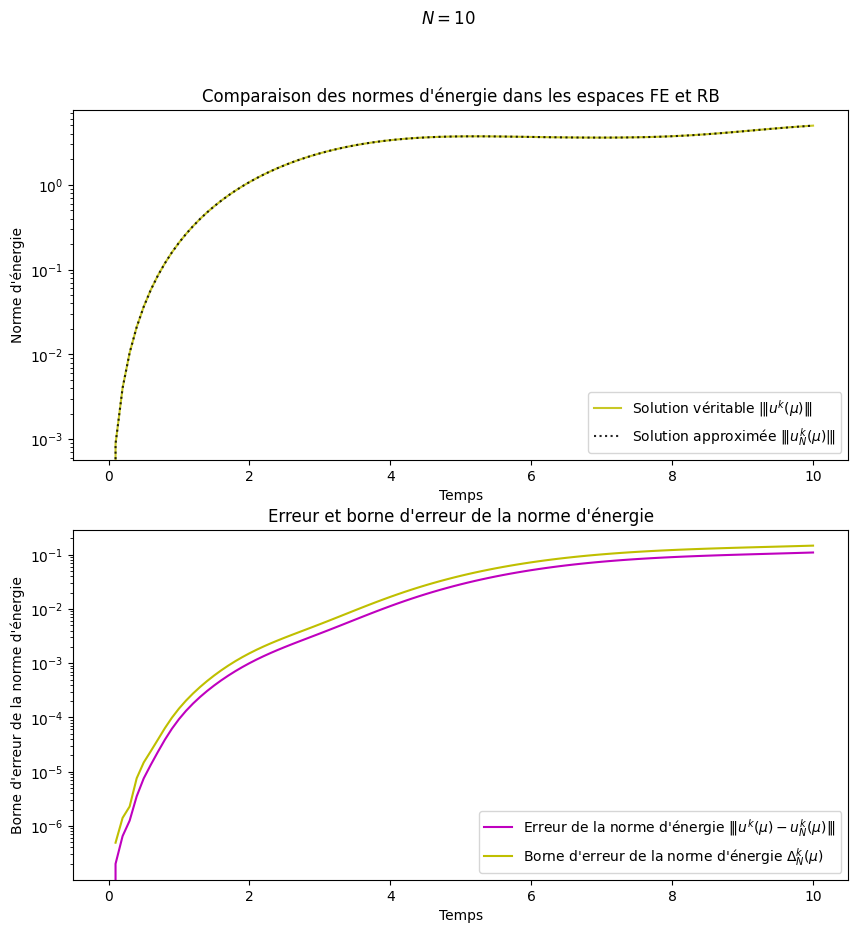

In [38]:
N = 10
Z = ZGreedy[:, :N]

testErrors(Z, "$N=10$")

##### $N=N_{max}$

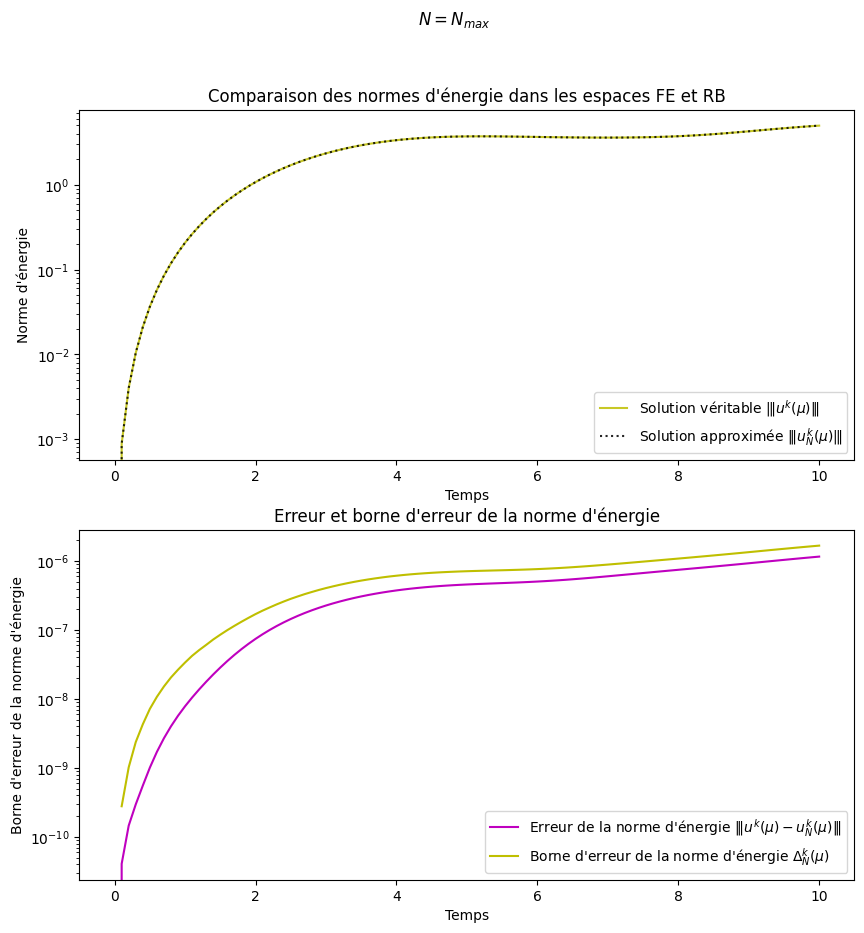

In [39]:
testErrors(ZGreedy, "$N=N_{max}$")

Les graphiques confirment que l'échantillon construit par l'algorithme POD-greedy est bien meilleur que l'échantillon aléatoire utilisé dans la Partie 1.

- **Effectivités moyennes**

L'effectivité utilisée est une moyenne sur l'échantillon de test $\Xi_{\mathrm{train}}$ et les pas de temps.
$$
    \bar{\eta}^{\mu} = \frac{1}{n_{test}\, K} \sum_{\mu \in \Xi_{\mathrm{train}}} \sum_{k=1}^K \frac{\Delta^k_N (\mu)}{|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|}
$$

In [40]:
CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, ZGreedy)

In [41]:
%%time
nTest, K, tMax, niter = 15, 100, 10, 100
Bis = logmu.rvs(size=nTest)
dt = tMax / K
g = gCos(np.linspace(0, tMax, K+1))
Nmax = ZGreedy.shape[1]
effs = np.zeros((Nmax, nTest, K))

AnqList, FnList, MnList = [], [], []

for N in range(Nmax):
    Anq, Fn, _, Mn = RBOffData(ZGreedy[:, :N+1], Ahq, Fh, Lh, Mh)
    AnqList.append(Anq)
    FnList.append(Fn)
    MnList.append(Mn)

for i, Bi in enumerate(Bis):
    mu = buildMu(Bi)
    Ah = assembleA(mu, Ahq)
    UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)

    for N in range(Nmax):
        UnList = computeSol(mu, AnqList[N], FnList[N], MnList[N], g, dt)
        UhZUn = UhList - ZGreedy[:, :N+1] @ UnList

        enNormErrors = energyNorm(UhZUn, Mh, Ah, dt, K+1)
        effs[N, i] = offOnErrBounds(
            mu, K, UnList, g, dt, CC, CR, RR, CL, RL, LL) / enNormErrors[1:]

effMean = effs.mean(axis=2).mean(axis=1)

CPU times: total: 1.98 s
Wall time: 12.8 s


In [42]:
print("Effectivités moyennes")
for k in [0, 9, 19, 30, 41]:
    print("N =", k+1, " -- Effectivité moyenne =", effMean[[k]][0])

Effectivités moyennes
N = 1  -- Effectivité moyenne = 1.7582369879460622
N = 10  -- Effectivité moyenne = 1.6004886684454827
N = 20  -- Effectivité moyenne = 1.409051664058483
N = 31  -- Effectivité moyenne = 1.443223494568236
N = 42  -- Effectivité moyenne = 3.4102230447214055


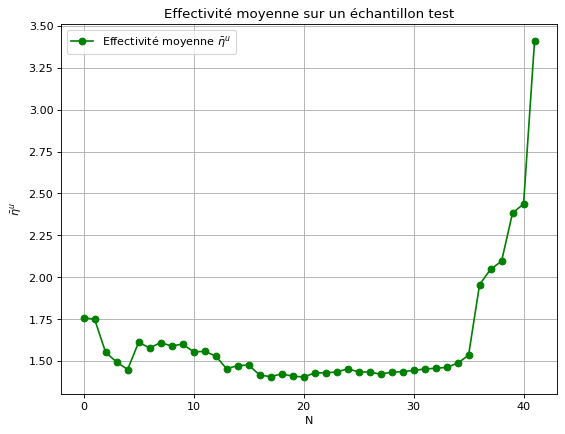

In [43]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(effMean, "go-", label="Effectivité moyenne $\\bar{\eta}^u$")
plt.xlabel("N")
plt.ylabel("$\\bar{\eta}^u$")
plt.title("Effectivité moyenne sur un échantillon test")
plt.legend()
plt.grid();

- **Comparaison du temps moyen**

On choisit $N$ de sorte que l'erreur dans la borne d'erreur de la sortie soit d'environ $1\%$.

In [44]:
def testOutput2(Z, mu):
    '''
    Calcule la borne d'erreur de la sortie
    '''
    K = 100
    tMax = 10
    dt = tMax / K
    Anq, Fn, Ln, Mn = RBOffData(Z, Ahq, Fh, Lh, Mh)
    g = gCos(np.linspace(0, tMax, K+1))

    UhList = computeSol(mu, Ahq, Fh, Mh, g, dt, K)
    UnList = computeSol(mu, Anq, Fn, Mn, g, dt, K)

    outputsFE = np.array([computeOutput(Lh, Uh) for Uh in UhList.T])
    outputsRB = np.array([computeOutput(Ln, Un) for Un in UnList.T])    
    outputErrors = np.abs(outputsFE - outputsRB)
    
    return np.mean(outputErrors[1:]/outputsFE[1:])

In [45]:
%%time
nTest = 15
Bis = logmu.rvs(size=nTest)

for n in range(2, ZGreedy.shape[1]):
    Z = ZGreedy[:, :n]
    temp = [testOutput2(Z, buildMu(Bi)) for Bi in Bis]

    error = np.mean(temp)
    print("N :", n, "    Erreur en sortie : %0.3f" % (error*100)+" %")
    if error <= 0.01:
        N = n
        break

N : 2     Erreur en sortie : 18.350 %
N : 3     Erreur en sortie : 5.386 %
N : 4     Erreur en sortie : 4.008 %
N : 5     Erreur en sortie : 3.491 %
N : 6     Erreur en sortie : 2.646 %
N : 7     Erreur en sortie : 2.218 %
N : 8     Erreur en sortie : 1.443 %
N : 9     Erreur en sortie : 1.086 %
N : 10     Erreur en sortie : 0.196 %
CPU times: total: 422 ms
Wall time: 3.44 s


On voit que, pour cet échantillon, lorsque $N$ vaut $10$ la précision de la borne d'erreur de la sortie $\leqslant 1\%$.

In [46]:
%%time
n = 3
Z = Z[:, :N]
K = 100
tMax = 10
dt = tMax / K
niter = 100
nTest = 15

Bis = logmu.rvs(size=nTest)
Anq, Fn, Ln, Mn = RBOffData(Z, Ahq, Fh, Lh, Mh)

outputsFE = np.empty((nTest, niter))
outputsRB = np.empty((nTest, niter))
CC, CR, RR, CL, RL, LL = offRBRiesz(AhBar, Ahq, Fh, Mh, Z)

for i, Bi in enumerate(Bis):
    mu = buildMu(Bi)
    for k in (range(1, niter+1)):
        t = time()
        for _ in range(n):
            UhList = computeSol(mu, Ahq, Fh, Mh, g, dt)
            computeOutput(Lh, UhList[:, k])
        outputsFE[i, k-1] = (time() - t) / n

        t = time()
        for _ in range(n):
            UnList = computeSol(mu, Anq, Fn, Mn, g, dt)
            outputErrBounds(mu, k, UnList, g, dt, CC, CR, RR, CL, RL, LL, lHatNorm)
            computeOutput(Ln, UnList[:, k])
        outputsRB[i, k-1] = (time() - t) / n

timesFE = outputsFE.mean(axis=0)
timesRB = outputsRB.mean(axis=0)


CPU times: total: 34.8 s
Wall time: 3min 27s


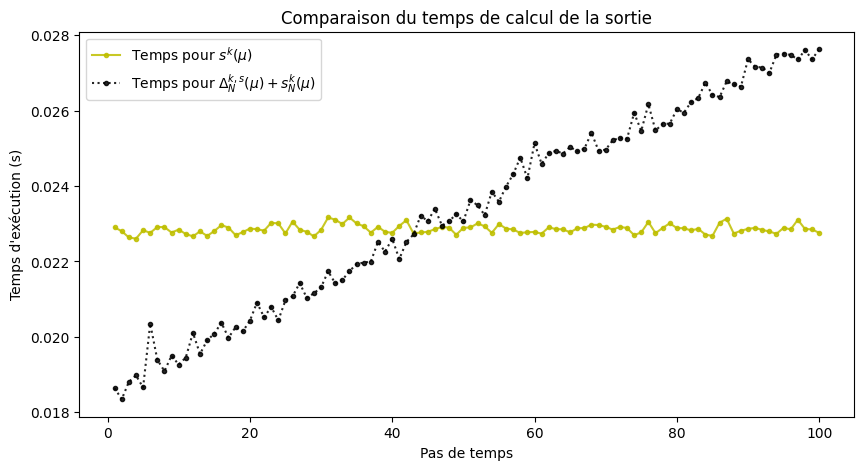

In [47]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

t = np.arange(niter) + 1
ax.plot(t, timesFE, "y.-", label="Temps pour $s^k(\mu)$", alpha=0.85)
ax.plot(t, timesRB, "k.:", label="Temps pour $\Delta^{k,s}_N(\mu) + s_N^k(\mu)$", alpha=0.85)
ax.set_xlabel("Pas de temps")
ax.set_ylabel("Temps d'exécution (s)")
ax.set_title("Comparaison du temps de calcul de la sortie")
ax.legend();

Dans ce cas particulier, le calcul exact est plus rapide que le calcul approché au delà d'environ 50 pas de temps. La même comparaison avec des valeurs de $N$ plus petite pourrait montrer de meilleures performances pour l'approche hors-ligne/en-ligne.

In [48]:
print('Temps de calcul FE moyen :', timesFE.mean())
print('Temps de calcul RB moyen :', timesRB.mean())

Temps de calcul FE moyen : 0.022858385933770077
Temps de calcul RB moyen : 0.02334931739171346


Le calcul hors-ligne/en-ligne est en moyenne légèrement plus rapide.